In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_utils import download_data, unzip_file

## Download Raw Data 

In [1]:
download_data(competition_name="web-traffic-time-series-forecasting")

In [18]:
unzip_file(
    zip_file_path='data/web-traffic-time-series-forecasting/train_2.csv.zip',
    target_folder='data/web-traffic-time-series-forecasting/'
)

In [19]:
data_file_path = 'data/web-traffic-time-series-forecasting/train_2.csv'
data = pd.read_csv(data_file_path)
data.rename(columns={
    'Page': 'page'
}, inplace=True)
data.shape

(145063, 804)

In [20]:
data.set_index('page', inplace=True)
data = data.T
data.index = pd.to_datetime(data.index)
data.head()

page,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,...,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_spider,Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider,Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider,Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider,Hasta_el_último_hombre_es.wikipedia.org_all-access_spider,Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
2015-07-01,18.0,11.0,1.0,35.0,NaN,12.0,NaN,118.0,5.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,11.0,14.0,0.0,13.0,NaN,7.0,NaN,26.0,23.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,5.0,15.0,1.0,10.0,NaN,4.0,NaN,30.0,14.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-04,13.0,18.0,1.0,94.0,NaN,5.0,NaN,24.0,12.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-05,14.0,11.0,0.0,4.0,NaN,20.0,NaN,29.0,9.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


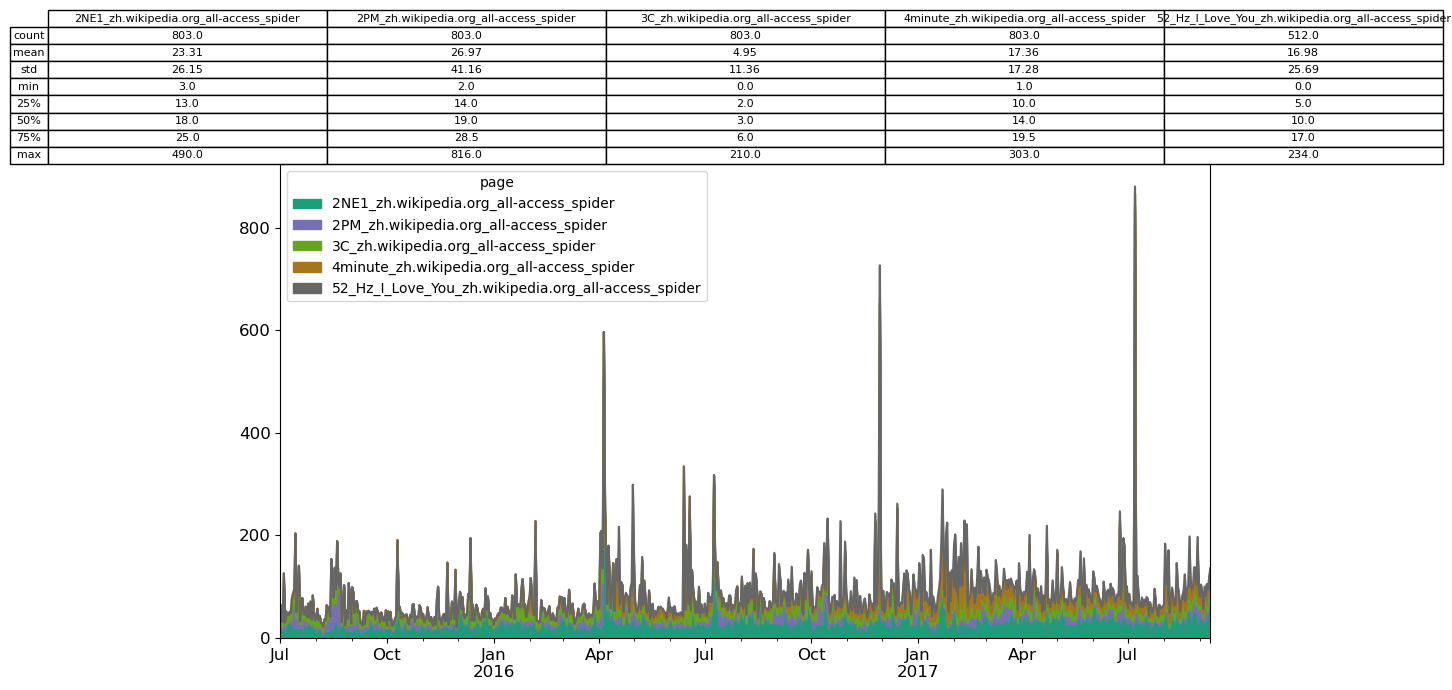

In [38]:
ax = data.iloc[:, :5].plot.area(figsize=(12, 6), fontsize=12, colormap='Dark2')

df_summary = data.iloc[:, :5].describe().round(2)

table = ax.table(
    cellText=df_summary.values,
    colWidths=[0.3] * len(data.iloc[:, :5].columns),
    rowLabels=df_summary.index,
    colLabels=df_summary.columns,
    loc='top',
    cellLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(8)

plt.subplots_adjust(top=0.9)

plt.show()

### Meta Data Retrieval

In [84]:
import requests
from datetime import datetime, timedelta

def get_wikipedia_revisions_range(article_title, start_date, end_date):
    # Convert the input dates to the required format
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d') + timedelta(days=1)

    start_date_str = start_date_dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    end_date_str = end_date_dt.strftime('%Y-%m-%dT%H:%M:%SZ')

    revisions = []
    rvcontinue = None

    while True:
        # Set up the API request parameters
        params = {
            'action': 'query',
            'format': 'json',
            'prop': 'revisions',
            'titles': article_title,
            'rvstart': end_date_str,
            'rvend': start_date_str,
            'rvlimit': 'max',
            'rvprop': 'ids|timestamp|user|userid|size|comment|tags',
        }
        
        if rvcontinue:
            params['rvcontinue'] = rvcontinue

        url = 'https://en.wikipedia.org/w/api.php'
        
        response = requests.get(url, params=params)
        data = response.json()

        # Extract the revisions from the response
        pages = data['query']['pages']
        for page_id, page_data in pages.items():
            if 'revisions' in page_data:
                revisions.extend(page_data['revisions'])

        if 'continue' in data:
            rvcontinue = data['continue']['rvcontinue']
        else:
            break

    return revisions

article_title = "Northeastern_University"
start_date = "2024-04-18"
end_date = "2024-05-08"
revisions = get_wikipedia_revisions_range(article_title, start_date, end_date)
for rev in revisions:
    revid = rev.get('revid', 'N/A')
    timestamp = rev.get('timestamp', 'N/A')
    user = rev.get('user', 'N/A')
    userid = rev.get('userid', 'N/A')
    size = rev.get('size', 'N/A')
    comment = rev.get('comment', 'N/A')
    tags = rev.get('tags', [])
    print(f"Revision ID: {revid}, Timestamp: {timestamp}, User: {user}, User ID: {userid}, Size: {size}, Comment: {comment}, Tags: {tags}")

Revision ID: 1222626940, Timestamp: 2024-05-07T00:36:34Z, User: ElKevbo, User ID: 217538, Size: 117411, Comment: this is already in the lede and we don't need it here twice, Tags: ['mw-manual-revert', 'wikieditor']
Revision ID: 1222624859, Timestamp: 2024-05-07T00:19:51Z, User: Harrkaep, User ID: 43238778, Size: 117496, Comment: Added its research distinction. First graph., Tags: ['visualeditor', 'mw-reverted']
Revision ID: 1222344297, Timestamp: 2024-05-05T13:33:48Z, User: ElKevbo, User ID: 217538, Size: 117411, Comment: /* See also */ linked in the body, Tags: ['wikieditor']
Revision ID: 1222344270, Timestamp: 2024-05-05T13:33:27Z, User: ElKevbo, User ID: 217538, Size: 117450, Comment: /* Colleges and schools */ change to bullets and link to business school article, Tags: ['wikieditor']
Revision ID: 1222344008, Timestamp: 2024-05-05T13:31:09Z, User: ElKevbo, User ID: 217538, Size: 117449, Comment: /* Notable alumni and faculty */ this completely unsourced, massive run on sentence wit

- **ids**: The unique identifier for each revision.
- **timestamp**: The date and time when the revision was made.
- **user**: The username of the contributor who made the revision.
- **userid**: The numerical ID of the contributor.
- **size**: The size of the page (in bytes) after the revision.
- **comment**: The edit summary or comment provided by the contributor.
- **tags**: Tags applied to the revision


Found from [Wikipedia Speical:Tags page](https://en.wikipedia.org/wiki/Special:Tags)
- **mobile edit**: Indicates increased accessibility and traffic from mobile devices.
- **mobile web edit**: Reflects trends in mobile web usage, potentially correlating with view spikes.
- **mw-reverted**: Signifies controversial edits, often leading to increased views.
- **mw-undo**: Similar to `mw-reverted`, indicating significant changes or conflicts.
- **mw-rollback**: Indicates high activity or controversial changes, likely driving views.
- **mobile app edit**: Usage of mobile apps can correlate with overall traffic trends.
- **android app edit**: Specific to Android users, useful for understanding platform-specific trends.
- **ios app edit**: Specific to iOS users, useful for understanding platform-specific trends.
- **mw-new-redirect**: Creation of new redirects can increase traffic through different paths.
- **mw-removed-redirect**: Removal of redirects can affect traffic patterns.
- **mw-blank**: Indicates vandalism or significant content changes, potentially impacting views.
- **mw-changed-redirect-target**: Changes in redirect targets can influence how users reach the page.


### Retrieve Meta data and Aggregate on Day level

In [103]:
import pandas as pd
from datetime import datetime, timedelta
import requests

def fetch_revision_data(article_title, start_date, end_date):
    start_date_str = start_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    end_date_str = end_date.strftime('%Y-%m-%dT%H:%M:%SZ')
    revisions = []
    rvcontinue = None

    while True:
        params = {
            'action': 'query',
            'format': 'json',
            'prop': 'revisions',
            'titles': article_title,
            'rvstart': end_date_str,
            'rvend': start_date_str,
            'rvlimit': 'max',
            'rvprop': 'ids|timestamp|user|userid|size|comment|tags',
        }
        if rvcontinue:
            params['rvcontinue'] = rvcontinue

        url = 'https://en.wikipedia.org/w/api.php'
        response = requests.get(url, params=params)
        data = response.json()

        pages = data['query']['pages']
        for page_id, page_data in pages.items():
            if 'revisions' in page_data:
                revisions.extend(page_data['revisions'])

        if 'continue' in data:
            rvcontinue = data['continue']['rvcontinue']
        else:
            break

    return revisions

def calculate_bytes_added(df):
    df = df.sort_values(by='timestamp').copy()
    df['prev_size'] = df.groupby('date')['size'].shift(1).fillna(df['size'])
    df['bytes_added'] = df['size'] - df['prev_size']
    return df

def aggregate_daily_data(revisions):
    df = pd.DataFrame(revisions)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    tag_columns = [
        'mobile edit', 'mobile web edit', 'visualeditor', 'mw-reverted', 'mw-undo',
        'mw-rollback', 'mobile app edit', 'android app edit', 'ios app edit',
        'contenttranslation', 'visualeditor-switched', 'mw-new-redirect',
        'mw-removed-redirect', 'mw-blank', 'mw-changed-redirect-target'
    ]

    for tag in tag_columns:
        df[tag] = df['tags'].apply(lambda tags: tag in tags if isinstance(tags, list) else False)

    df = calculate_bytes_added(df)

    daily_aggregation = df.groupby('date').agg(
        total_edits=('revid', 'count'),
        total_bytes_added=('bytes_added', 'sum'),
        unique_editors=('userid', pd.Series.nunique),
        **{tag: (tag, 'sum') for tag in tag_columns},
        end_of_day_size=('size', 'last')
    ).reset_index()
    
    return daily_aggregation


article_title = "Northeastern_University"
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)
revisions = fetch_revision_data(article_title, start_date, end_date)
daily_data = aggregate_daily_data(revisions)


daily_data.head()

,date,total_edits,total_bytes_added,unique_editors,mobile edit,mobile web edit,visualeditor,mw-reverted,mw-undo,mw-rollback,mobile app edit,android app edit,ios app edit,contenttranslation,visualeditor-switched,mw-new-redirect,mw-removed-redirect,mw-blank,mw-changed-redirect-target,end_of_day_size
0,2023-01-03,2,391.0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,134330
1,2023-01-04,1,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,141319
2,2023-01-05,2,223.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137335
3,2023-01-07,1,0.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,137348
4,2023-01-13,1,0.0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,137413
